In [93]:
import pandas as pd
from sodapy import Socrata
#aqui sacamos las tablas de datos de hospitales y desfibriladores 
client = Socrata("analisi.transparenciacatalunya.cat", None)

desfibriladors = client.get_all("wpud-ukyg")
hospitales = client.get_all("8gmd-gz7i")

df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_desfibriladors = df_desfibriladors.drop_duplicates(subset='numero_serie', keep='first')
#df_desfibriladors

df_hospitales = pd.DataFrame.from_records(hospitales) 
df_hospitals = df_hospitales[df_hospitales["categoria"].str.contains(r"Salut\|Centres", na=False)]
df_hospitals = df_hospitals.drop_duplicates(subset='idequipament', keep='first')
df_hospi = df_hospitals[['codi_municipi']]

defi_count = df_desfibriladors.groupby('codi_municipi').size().reset_index(name='num_defi')
hospi_count = df_hospi.groupby('codi_municipi').size().reset_index(name='num_hospi')

df_hospitals.columns





Index(['idequipament', 'alies', 'nom', 'categoria', 'tipus_via', 'via',
       'sufix_via', 'num', 'cpostal', 'poblacio', 'codi_municipi', 'comarca',
       'telefon1', 'telefon2', 'fax', 'utmx', 'utmy', 'longitud', 'latitud',
       'email', 'data_modificacio', 'propietats', 'localitzacio',
       ':@computed_region_wvic_k925', ':@computed_region_bh64_c7uy', 'web'],
      dtype='object')

In [94]:

# Extract defibrillator coordinates
df_desf_coords = df_desfibriladors[['longitud', 'latitud']].copy()
df_desf_coords['longitud'] = pd.to_numeric(df_desf_coords['longitud'], errors='coerce')
df_desf_coords['latitud'] = pd.to_numeric(df_desf_coords['latitud'], errors='coerce')
df_desf_coords = df_desf_coords.dropna()
desf_points = df_desf_coords[['longitud', 'latitud']].values

# Extract hospital coordinates
df_hospi_coords = df_hospitals[['longitud', 'latitud']].copy()
df_hospi_coords['longitud'] = pd.to_numeric(df_hospi_coords['longitud'], errors='coerce')
df_hospi_coords['latitud'] = pd.to_numeric(df_hospi_coords['latitud'], errors='coerce')
df_hospi_coords = df_hospi_coords.dropna()
hospi_points = df_hospi_coords[['longitud', 'latitud']].values

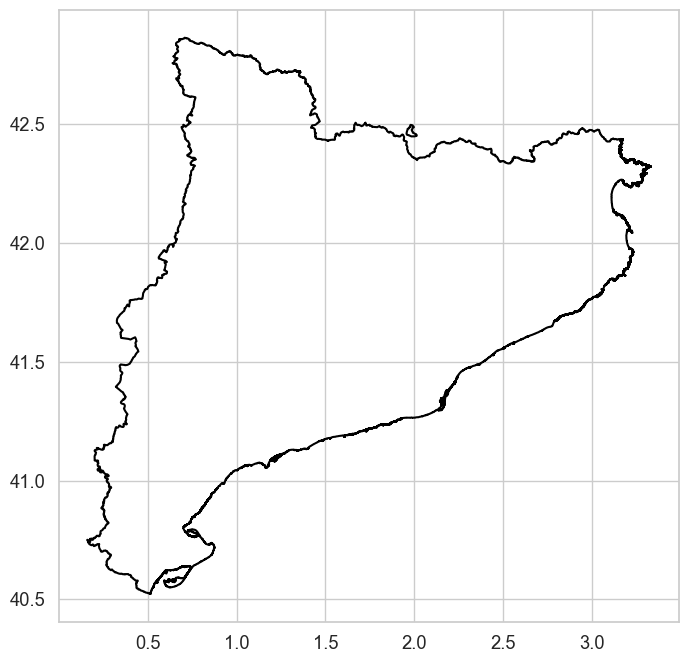

In [95]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree


# Read Catalonia boundary from JSON
import json
with open('carto/divisions-administratives-v2r1-catalunya-5000-20250730.json', 'r') as f:
    cat_geojson = json.load(f)

cat_geojson
#put geojson to geodataframe with consistent CRS and geographical geometry
cat_gdf = gpd.GeoDataFrame.from_features(cat_geojson["features"])
cat_gdf = cat_gdf.set_crs(epsg=4326)
#plot boundary
fig, ax = plt.subplots(figsize=(8, 8))
cat_gdf.boundary.plot(ax=ax, color='black')
plt.show()

In [96]:


# Load municipality geometries
data_dir = "carto/"
municipis = gpd.read_file(data_dir + "muni.json")
municipis["NOMMUNI"] = municipis["NOMMUNI"].str.upper().str.strip()

# Calculate centroids for each municipality
municipis['centroid_lon'] = municipis.geometry.centroid.x
municipis['centroid_lat'] = municipis.geometry.centroid.y

# Prepare defibrillator data
df_desf_coords = df_desfibriladors.copy()
df_desf_coords['longitud'] = pd.to_numeric(df_desf_coords['longitud'], errors='coerce')
df_desf_coords['latitud'] = pd.to_numeric(df_desf_coords['latitud'], errors='coerce')
df_desf_coords['municipi'] = df_desf_coords['municipi'].str.upper().str.strip()

# Merge with municipality centroids
df_desf_coords = df_desf_coords.merge(
    municipis[['NOMMUNI', 'centroid_lon', 'centroid_lat']],
    left_on='municipi',
    right_on='NOMMUNI',
    how='left'
)

# Fill NaN coordinates with municipality centroids
df_desf_coords['longitud'] = df_desf_coords['longitud'].fillna(df_desf_coords['centroid_lon'])
df_desf_coords['latitud'] = df_desf_coords['latitud'].fillna(df_desf_coords['centroid_lat'])

# Remove any remaining NaN values
df_desf_coords = df_desf_coords.dropna(subset=['longitud', 'latitud'])

# Extract final coordinates
desf_points = df_desf_coords[['longitud', 'latitud']].values

print(f"Total defibrillators with coordinates: {len(desf_points)}")

# Get Catalonia bounds
min_lon, min_lat, max_lon, max_lat = municipis.total_bounds

# Create grid
grid_spacing = 0.01  # degrees (adjust for resolution)
lon_grid = np.arange(min_lon, max_lon, grid_spacing)
lat_grid = np.arange(min_lat, max_lat, grid_spacing)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
grid_points = np.c_[lon_mesh.ravel(), lat_mesh.ravel()]






Total defibrillators with coordinates: 11441


C:\Users\Ale\AppData\Local\Temp\ipykernel_6668\4251137198.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  municipis['centroid_lon'] = municipis.geometry.centroid.x
C:\Users\Ale\AppData\Local\Temp\ipykernel_6668\4251137198.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  municipis['centroid_lat'] = municipis.geometry.centroid.y


In [97]:
# Find nearest defibrillator for each point
tree = cKDTree(desf_points)
distances, _ = tree.query(grid_points, k=1)

# Find nearest hospital for each point
tree_hospi = cKDTree(hospi_points)
distances_hospi, _ = tree_hospi.query(grid_points, k=1)


# Find neasrest hospital or defibrillator
min_distances = np.minimum(distances, distances_hospi)

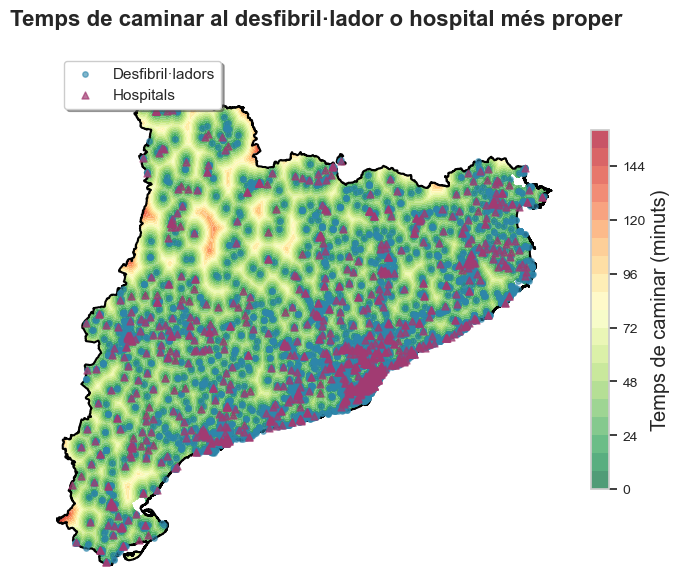

In [98]:
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create figure
fig, ax = plt.subplots(figsize=(8,6))

# Plot Catalonia boundary
cat_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Mask points outside Catalonia
from shapely.geometry import Point
municipis = municipis[municipis.is_valid]
catalonia_union = municipis.unary_union

# Plot defibrillator points inside Catalonia
desf_gdf = gpd.GeoDataFrame(
    df_desf_coords,
    geometry=gpd.points_from_xy(df_desf_coords['longitud'], df_desf_coords['latitud']),
    crs=municipis.crs
)
desf_inside = desf_gdf[desf_gdf.geometry.within(catalonia_union)]
desf_inside.plot(ax=ax, color='#2E86AB', markersize=15, alpha=0.6, label='Desfibril·ladors', zorder=3)

hospi_gdf = gpd.GeoDataFrame(
    df_hospi_coords,
    geometry=gpd.points_from_xy(df_hospi_coords['longitud'], df_hospi_coords['latitud']),
    crs=municipis.crs
)
hospi_inside = hospi_gdf[hospi_gdf.geometry.within(catalonia_union)]
hospi_inside.plot(ax=ax, color='#A23B72', markersize=25, alpha=0.7, label='Hospitals', marker='^', zorder=3)

# Convert to kilometers and walking time
lat_mean = np.mean(lat_mesh)
km_per_deg = 111.320 * np.cos(np.radians(lat_mean))
distances_km = min_distances * km_per_deg
time_minutes = (distances_km / 5) * 60
time_grid = time_minutes.reshape(lon_mesh.shape)

# Mask points outside Catalonia
mask = np.zeros(time_grid.shape, dtype=bool)
for i in range(lon_mesh.shape[0]):
    for j in range(lon_mesh.shape[1]):
        point = Point(lon_mesh[i, j], lat_mesh[i, j])
        if not catalonia_union.contains(point):
            mask[i, j] = True
time_grid_masked = np.ma.array(time_grid, mask=mask)

# Plot heatmap with custom colormap
contour = ax.contourf(
    lon_mesh, 
    lat_mesh, 
    time_grid_masked,
    levels=20,
    cmap='RdYlGn_r',
    alpha=0.7
)

# Add colorbar with better styling
cbar = plt.colorbar(contour, ax=ax, label='Temps de caminar (minuts)', shrink=0.7, pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Set title and legend
ax.set_title("Temps de caminar al desfibril·lador o hospital més proper", 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=11)

# Remove axis
ax.axis('off')

plt.tight_layout()
plt.show()

Municipalities processed: 944


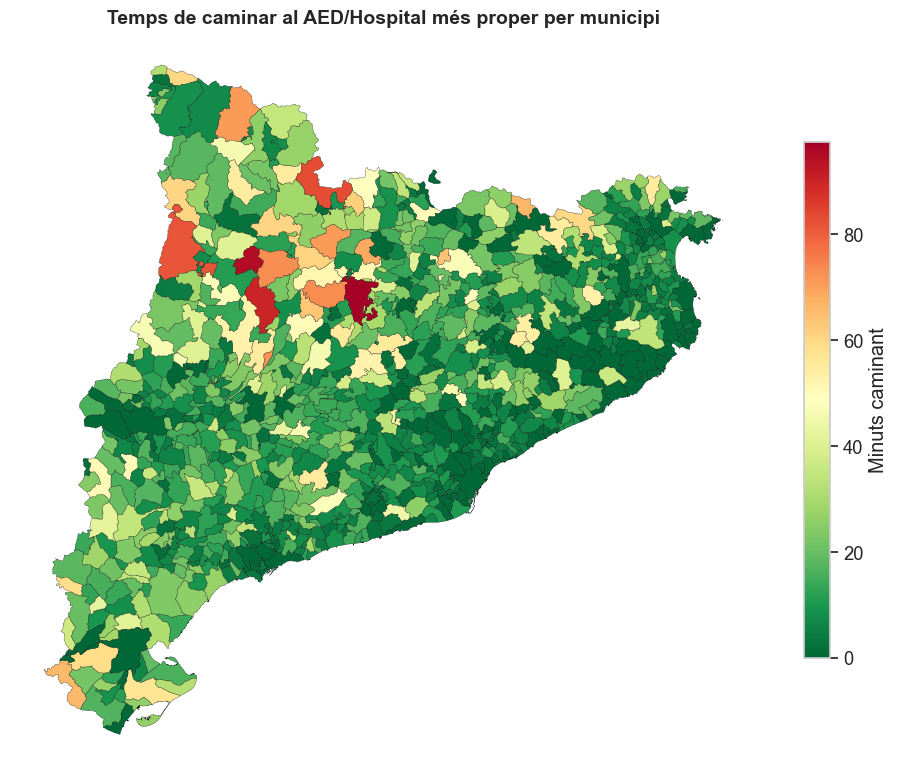

In [99]:
# Merge defibrillators and hospitals, calculate walking time per municipality
from scipy.spatial import cKDTree
import numpy as np

# Combine all AED + hospital points
all_points = np.vstack([desf_points, hospi_points])

# Build single tree for all emergency points
tree_all = cKDTree(all_points)

# Calculate distance from each municipality centroid to nearest AED/hospital
centroids = municipis[['centroid_lon', 'centroid_lat']].values
distances, _ = tree_all.query(centroids, k=1)

# Convert to km and walking time (consistent formula)
KM_PER_DEG = 111.320 * np.cos(np.radians(centroids[:, 1].mean()))
WALKING_SPEED_KMH = 5

municipis['dist_km'] = distances * KM_PER_DEG
municipis['walk_time_min'] = (municipis['dist_km'] / WALKING_SPEED_KMH) * 60

print(f"Municipalities processed: {len(municipis)}")

# Choropleth map: walking time by municipality
fig, ax = plt.subplots(figsize=(10, 8))

municipis.plot(
    column='walk_time_min',
    ax=ax,
    legend=True,
    cmap='RdYlGn_r',
    edgecolor='black',
    linewidth=0.2,
    legend_kwds={'label': 'Minuts caminant', 'shrink': 0.7}
)

ax.set_title('Temps de caminar al AED/Hospital més proper per municipi', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


In [100]:
municipis.columns

Index(['CODIMUNI', 'NOMMUNI', 'CAPMUNI', 'AREAM5000', 'CODICOMAR', 'NOMCOMAR',
       'CAPCOMAR', 'CODIVEGUE', 'NOMVEGUE', 'CAPVEGUE', 'CODIPROV', 'NOMPROV',
       'CAPPROV', 'geometry', 'centroid_lon', 'centroid_lat', 'dist_km',
       'walk_time_min'],
      dtype='object')

ESTADÍSTIQUES D'ACCESSIBILITAT AED/HOSPITAL
Mínim          :   0.00 minuts
Mitjana        :  14.52 minuts
Mediana        :  10.34 minuts
Percentil 95   :  47.76 minuts
Màxim          :  97.38 minuts

📊 29.0% dels municipis estan a ≤5 min d'un AED/Hospital
📊 49.0% dels municipis estan a ≤10 min
⚠️  34.9% dels municipis superen els 15 min


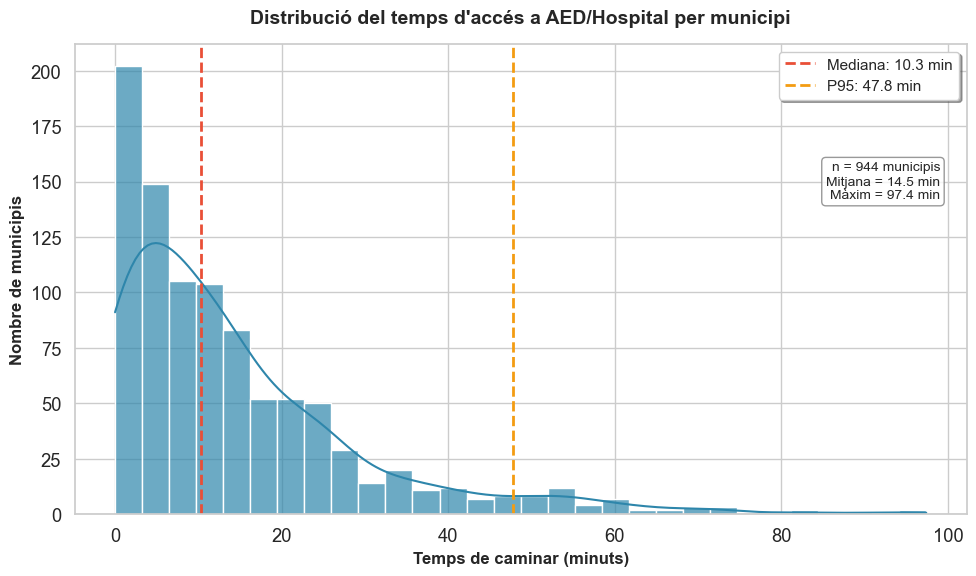

In [101]:
import seaborn as sns

# Summary statistics
stats = {
    'Mínim': municipis['walk_time_min'].min(),
    'Mitjana': municipis['walk_time_min'].mean(),
    'Mediana': municipis['walk_time_min'].median(),
    'Percentil 95': municipis['walk_time_min'].quantile(0.95),
    'Màxim': municipis['walk_time_min'].max()
}

print("=" * 50)
print("ESTADÍSTIQUES D'ACCESSIBILITAT AED/HOSPITAL")
print("=" * 50)
for k, v in stats.items():
    print(f"{k:15}: {v:6.2f} minuts")
print("=" * 50)

# Calculate percentage within thresholds
pct_under_5 = (municipis['walk_time_min'] <= 5).mean() * 100
pct_under_10 = (municipis['walk_time_min'] <= 10).mean() * 100
pct_over_15 = (municipis['walk_time_min'] > 15).mean() * 100

print(f"\n📊 {pct_under_5:.1f}% dels municipis estan a ≤5 min d'un AED/Hospital")
print(f"📊 {pct_under_10:.1f}% dels municipis estan a ≤10 min")
print(f"⚠️  {pct_over_15:.1f}% dels municipis superen els 15 min")

# Professional histogram
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

# Histogram with KDE
sns.histplot(
    municipis['walk_time_min'], 
    bins=30, 
    kde=True, 
    color='#2E86AB',
    edgecolor='white',
    alpha=0.7,
    ax=ax
)

# Add vertical lines for key percentiles
ax.axvline(stats['Mediana'], color='#E94F37', linestyle='--', linewidth=2, label=f"Mediana: {stats['Mediana']:.1f} min")
ax.axvline(stats['Percentil 95'], color='#F39C12', linestyle='--', linewidth=2, label=f"P95: {stats['Percentil 95']:.1f} min")

# Styling
ax.set_xlabel('Temps de caminar (minuts)', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre de municipis', fontsize=12, fontweight='bold')
ax.set_title('Distribució del temps d\'accés a AED/Hospital per municipi', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)

# Add text box with stats
textstr = f"n = {len(municipis)} municipis\nMitjana = {stats['Mitjana']:.1f} min\nMàxim = {stats['Màxim']:.1f} min"
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
ax.text(0.97, 0.75, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

$\huge{Additional \; analysis}$

In [103]:

url = "https://www.idescat.cat/serveis/consultes/ca/censph_10_mun_2024.csv"
df_cens = pd.read_csv(url, sep=";", encoding="utf-8")


"""
Normalise municipal data to make sure all have the same codes
"""
municipis = municipis.rename(columns={'CODIMUNI': 'codi_municipi', 'NOMMUNI':'municipi', 'NOMCOMAR': 'comarca'})



municipis['codi_municipi'] = municipis['codi_municipi'].astype(str).apply(
    lambda x: x[:-1] if len(x) == 6 else x
)
defi_count['codi_municipi'] = defi_count['codi_municipi'].astype(str).apply(
    lambda x: x[:-1] if len(x) == 6 else x
)
def fix_code(x):
    x = str(x)  # ensure string
    # Add leading zero if first digit is 8 and length < 6
    if x.startswith('8') and len(x) < 6:
        x = '0' + x
    # Truncate last digit if length is 6
    if len(x) == 6:
        x = x[:-1]
    return x

hospi_count['codi_municipi'] = hospi_count['codi_municipi'].apply(fix_code)

# Filter rows where edat == "total"
df_cens_total = df_cens[(df_cens["edat"] == "total") & (df_cens["sexe"] == "total")].copy()
df_cens_total = df_cens_total[df_cens_total["valor"] <= 5000000]
df_cens_total = df_cens_total.reset_index(drop=True)
df_cens_total = df_cens_total.rename(columns={"valor": "pob"})

# Keep only geo name and population
df_cens_pop = df_cens_total[["geo", "pob"]].copy()

df_cens_pop = df_cens_pop.rename(columns={'geo': 'codi_municipi'})
df_cens_pop['codi_municipi'] = df_cens_pop['codi_municipi'].apply(fix_code)



C:\Users\Ale\AppData\Local\Temp\ipykernel_6668\3991539779.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens = pd.read_csv(url, sep=";", encoding="utf-8")


In [110]:
# Merge population data
municipis = municipis.merge(df_cens_pop, left_on='municipi', right_on='codi_municipi', how='left')


municipis.columns

Index(['codi_municipi_x', 'municipi', 'CAPMUNI', 'AREAM5000', 'CODICOMAR',
       'comarca', 'CAPCOMAR', 'CODIVEGUE', 'NOMVEGUE', 'CAPVEGUE', 'CODIPROV',
       'NOMPROV', 'CAPPROV', 'geometry', 'centroid_lon', 'centroid_lat',
       'dist_km', 'walk_time_min', 'codi_municipi_y', 'pob_x', 'codi_municipi',
       'pob_y'],
      dtype='object')

Text(0.5, 1.0, 'Accessibilitat AED vs Mida del Municipi')

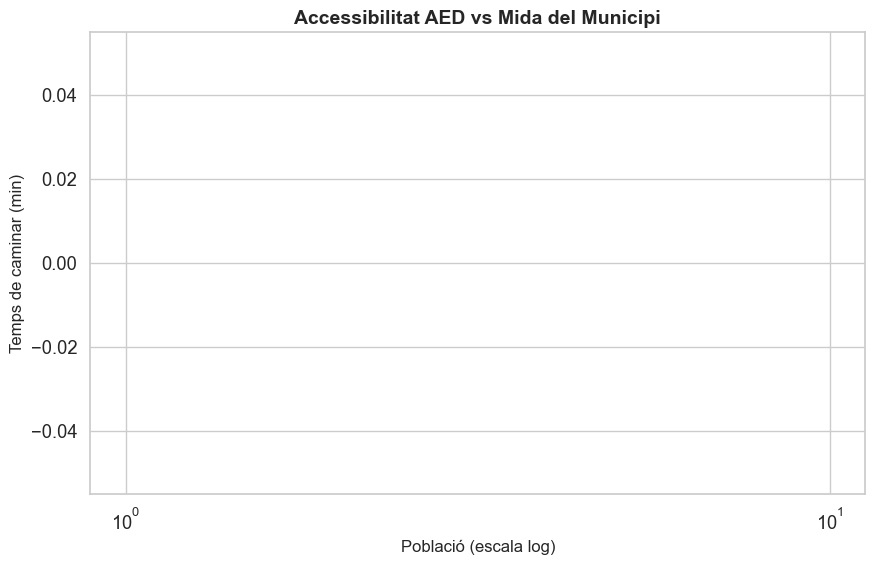

In [ ]:
# Scatter: walking time vs population
df_scatter = municipis[['municipi', 'walk_time_min']].copy()
df_scatter = df_scatter.merge(df_cens_pop, left_on='municipi', right_on='codi_municipi', how='left')
df_scatter = df_scatter.dropna()

df_scatter['pob'] = pd.to_numeric(df_scatter['pob'], errors='coerce')
df_scatter = df_scatter.dropna(subset=['pob'])

df_scatter.columns
df_scatter.head()

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_scatter['pob'], df_scatter['walk_time_min'], alpha=0.5, c='#2E86AB', edgecolor='white')
ax.set_xscale('log')
ax.set_xlabel('Població (escala log)', fontsize=12)
ax.set_ylabel('Temps de caminar (min)', fontsize=12)
ax.set_title('Accessibilitat AED vs Mida del Municipi', fontsize=14, fontweight='bold')





In [111]:
# Identify top 5 municipalities for new AED placement
worst_access = municipis.nlargest(5, 'walk_time_min')[['NOMMUNI', 'walk_time_min', 'centroid_lon', 'centroid_lat']]

print("=" * 60)
print("TOP 5 UBICACIONS RECOMANADES PER NOUS AED")
print("=" * 60)
for i, (_, row) in enumerate(worst_access.iterrows(), 1):
    print(f"{i}. {row['NOMMUNI']}: {row['walk_time_min']:.1f} min")
    print(f"   Coordenades: ({row['centroid_lat']:.4f}, {row['centroid_lon']:.4f})")
print("=" * 60)

# Map with suggested locations
fig, ax = plt.subplots(figsize=(12, 10))
municipis.plot(column='walk_time_min', ax=ax, cmap='RdYlGn_r', edgecolor='gray', linewidth=0.1, alpha=0.7)
ax.scatter(worst_access['centroid_lon'], worst_access['centroid_lat'], 
           c='red', s=200, marker='*', edgecolor='black', linewidth=1, label='Ubicacions recomanades', zorder=5)
for _, row in worst_access.iterrows():
    ax.annotate(row['NOMMUNI'], (row['centroid_lon'], row['centroid_lat']), fontsize=8, fontweight='bold')
ax.set_title('Ubicacions Recomanades per Nous AED', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.axis('off')
plt.show()

KeyError: "['NOMMUNI'] not in index"

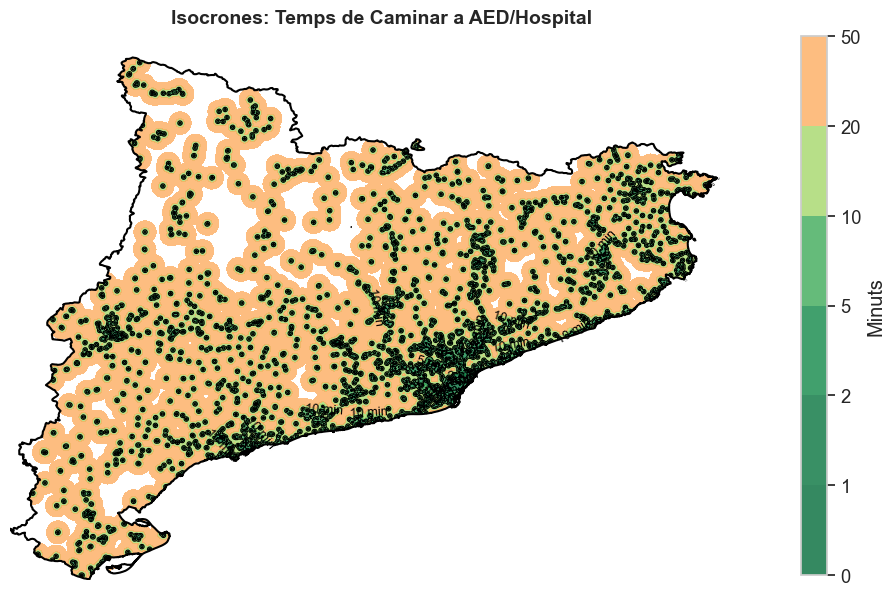

In [112]:
# High-resolution isochrone map
grid_spacing = 0.005  # ~500m resolution
lon_grid = np.arange(min_lon, max_lon, grid_spacing)
lat_grid = np.arange(min_lat, max_lat, grid_spacing)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
grid_points = np.c_[lon_mesh.ravel(), lat_mesh.ravel()]

# Calculate walking times
distances, _ = tree_all.query(grid_points, k=1)
time_grid = (distances * KM_PER_DEG / WALKING_SPEED_KMH) * 60
time_grid = time_grid.reshape(lon_mesh.shape)

# Mask outside Catalonia
mask = np.array([[not catalonia_union.contains(Point(lon_mesh[i,j], lat_mesh[i,j])) 
                  for j in range(lon_mesh.shape[1])] for i in range(lon_mesh.shape[0])])
time_grid_masked = np.ma.array(time_grid, mask=mask)

# Plot with isochrone contours
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.contourf(lon_mesh, lat_mesh, time_grid_masked, levels=[0,1,2,5,10,20,50], cmap='RdYlGn_r', alpha=0.8)
contours = ax.contour(lon_mesh, lat_mesh, time_grid_masked, levels=[1,2,5,10], colors='black', linewidths=0.8)
ax.clabel(contours, fmt='%d min', fontsize=9)
catalonia_boundary = gpd.GeoSeries([catalonia_union])
catalonia_boundary.boundary.plot(ax=ax, color='black', linewidth=1.5)
plt.colorbar(im, ax=ax, label='Minuts', shrink=0.7)
ax.set_title('Isocrones: Temps de Caminar a AED/Hospital', fontsize=14, fontweight='bold')
ax.axis('off')
plt.show()